# Predict and Eliminate Epidemic with Historical Data
Doris Lee (617001187)

## 2. Data Understanding

### 2.1 Collecting initial data

In [1]:
# Must be included at the beginning of each new notebook. App name: BDAS-dengue
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDAS-dengue').getOrCreate()

In [2]:
# Read Training Data Features file (dengue_features_train.csv). Schema is automatically configured.
features = spark.read.csv('dengue_features_train.csv', header=True, inferSchema=True)

In [3]:
# Show first 5 rows of features dataframe
features.head(5)

[Row(city='sj', year=1990, weekofyear=18, week_start_date=datetime.datetime(1990, 4, 30, 0, 0), ndvi_ne=0.1226, ndvi_nw=0.103725, ndvi_se=0.1984833, ndvi_sw=0.1776167, precipitation_amt_mm=12.42, reanalysis_air_temp_k=297.572857143, reanalysis_avg_temp_k=297.742857143, reanalysis_dew_point_temp_k=292.414285714, reanalysis_max_air_temp_k=299.8, reanalysis_min_air_temp_k=295.9, reanalysis_precip_amt_kg_per_m2=32.0, reanalysis_relative_humidity_percent=73.3657142857, reanalysis_sat_precip_amt_mm=12.42, reanalysis_specific_humidity_g_per_kg=14.0128571429, reanalysis_tdtr_k=2.62857142857, station_avg_temp_c=25.4428571429, station_diur_temp_rng_c=6.9, station_max_temp_c=29.4, station_min_temp_c=20.0, station_precip_mm=16.0),
 Row(city='sj', year=1990, weekofyear=19, week_start_date=datetime.datetime(1990, 5, 7, 0, 0), ndvi_ne=0.1699, ndvi_nw=0.142175, ndvi_se=0.1623571, ndvi_sw=0.1554857, precipitation_amt_mm=22.82, reanalysis_air_temp_k=298.211428571, reanalysis_avg_temp_k=298.442857143, re

In [4]:
# Read Training Data Labels file (dengue_labels_train.csv). Schema is automatically configured.
labels = spark.read.csv('dengue_labels_train.csv', header=True, inferSchema=True)

In [5]:
# Show labels dataframe
labels.show()

+----+----+----------+-----------+
|city|year|weekofyear|total_cases|
+----+----+----------+-----------+
|  sj|1990|        18|          4|
|  sj|1990|        19|          5|
|  sj|1990|        20|          4|
|  sj|1990|        21|          3|
|  sj|1990|        22|          6|
|  sj|1990|        23|          2|
|  sj|1990|        24|          4|
|  sj|1990|        25|          5|
|  sj|1990|        26|         10|
|  sj|1990|        27|          6|
|  sj|1990|        28|          8|
|  sj|1990|        29|          2|
|  sj|1990|        30|          6|
|  sj|1990|        31|         17|
|  sj|1990|        32|         23|
|  sj|1990|        33|         13|
|  sj|1990|        34|         21|
|  sj|1990|        35|         28|
|  sj|1990|        36|         24|
|  sj|1990|        37|         20|
+----+----+----------+-----------+
only showing top 20 rows



### 2.2 Describing the data

#### 2.2.1 Quantity

In [6]:
# Print number of rows and columns in features
print(features.count())
print(len(features.columns))

1456
24


In [7]:
# Print number of rows and columns in labels
print(labels.count())
print(len(labels.columns))

1456
4


#### 2.2.2 Spatial range

In [8]:
features.groupBy('city').count().orderBy('city').show()

+----+-----+
|city|count|
+----+-----+
|  iq|  520|
|  sj|  936|
+----+-----+



In [9]:
labels.groupBy('city').count().orderBy('city').show()

+----+-----+
|city|count|
+----+-----+
|  iq|  520|
|  sj|  936|
+----+-----+



#### 2.2.3 Temporal range

In [10]:
features.filter(features['city']=='sj').select(['city','year','weekofyear','week_start_date']).orderBy('week_start_date').show(5)
features.filter(features['city']=='sj').select(['city','year','weekofyear','week_start_date']).orderBy(features['week_start_date'].desc()).show(5)

+----+----+----------+--------------------+
|city|year|weekofyear|     week_start_date|
+----+----+----------+--------------------+
|  sj|1990|        18|1990-04-30 00:00:...|
|  sj|1990|        19|1990-05-07 00:00:...|
|  sj|1990|        20|1990-05-14 00:00:...|
|  sj|1990|        21|1990-05-21 00:00:...|
|  sj|1990|        22|1990-05-28 00:00:...|
+----+----+----------+--------------------+
only showing top 5 rows

+----+----+----------+--------------------+
|city|year|weekofyear|     week_start_date|
+----+----+----------+--------------------+
|  sj|2008|        17|2008-04-22 00:00:...|
|  sj|2008|        16|2008-04-15 00:00:...|
|  sj|2008|        15|2008-04-08 00:00:...|
|  sj|2008|        14|2008-04-01 00:00:...|
|  sj|2008|        13|2008-03-25 00:00:...|
+----+----+----------+--------------------+
only showing top 5 rows



In [11]:
features.filter(features['city']=='iq').select(['city','year','weekofyear','week_start_date']).orderBy('week_start_date').show(5)
features.filter(features['city']=='iq').select(['city','year','weekofyear','week_start_date']).orderBy(features['week_start_date'].desc()).show(5)

+----+----+----------+--------------------+
|city|year|weekofyear|     week_start_date|
+----+----+----------+--------------------+
|  iq|2000|        26|2000-07-01 00:00:...|
|  iq|2000|        27|2000-07-08 00:00:...|
|  iq|2000|        28|2000-07-15 00:00:...|
|  iq|2000|        29|2000-07-22 00:00:...|
|  iq|2000|        30|2000-07-29 00:00:...|
+----+----+----------+--------------------+
only showing top 5 rows

+----+----+----------+--------------------+
|city|year|weekofyear|     week_start_date|
+----+----+----------+--------------------+
|  iq|2010|        25|2010-06-25 00:00:...|
|  iq|2010|        24|2010-06-18 00:00:...|
|  iq|2010|        23|2010-06-11 00:00:...|
|  iq|2010|        22|2010-06-04 00:00:...|
|  iq|2010|        21|2010-05-28 00:00:...|
+----+----+----------+--------------------+
only showing top 5 rows



#### 2.2.6 Value types

In [12]:
features.printSchema()
labels.printSchema()

root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- week_start_date: timestamp (nullable = true)
 |-- ndvi_ne: double (nullable = true)
 |-- ndvi_nw: double (nullable = true)
 |-- ndvi_se: double (nullable = true)
 |-- ndvi_sw: double (nullable = true)
 |-- precipitation_amt_mm: double (nullable = true)
 |-- reanalysis_air_temp_k: double (nullable = true)
 |-- reanalysis_avg_temp_k: double (nullable = true)
 |-- reanalysis_dew_point_temp_k: double (nullable = true)
 |-- reanalysis_max_air_temp_k: double (nullable = true)
 |-- reanalysis_min_air_temp_k: double (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: double (nullable = true)
 |-- reanalysis_relative_humidity_percent: double (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: double (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: double (nullable = true)
 |-- reanalysis_tdtr_k: double (nullable = true)
 |-- station_avg_temp_c: double (

### 2.3 Data exploration

In [13]:
features.select(features.columns[:7]).describe().show()
features.select(features.columns[7:12]).describe().show()
features.select(features.columns[12:15]).describe().show()
features.select(features.columns[15:18]).describe().show()
features.select(features.columns[18:]).describe().show()
labels.describe().show()

+-------+----+------------------+------------------+-------------------+-------------------+-------------------+
|summary|city|              year|        weekofyear|            ndvi_ne|            ndvi_nw|            ndvi_se|
+-------+----+------------------+------------------+-------------------+-------------------+-------------------+
|  count|1456|              1456|              1456|               1262|               1404|               1434|
|   mean|null|2001.0315934065934|26.503434065934066|0.14229353741679884|0.13055257610470097|0.20378318902580198|
| stddev|null| 5.408313995800633|15.019437184985504|0.14053115314639278|0.11999906267761296|0.07385973904332575|
|    min|  iq|              1990|                 1|           -0.40625|            -0.4561|        -0.01553333|
|    max|  sj|              2010|                53|          0.5083571|          0.4544286|          0.5383143|
+-------+----+------------------+------------------+-------------------+-------------------+----

In [14]:
from pyspark.sql.functions import skewness
for col in features.columns[4:]:
    features.agg(skewness(features[col])).show()

+--------------------+
|   skewness(ndvi_ne)|
+--------------------+
|-0.11070943959821461|
+--------------------+

+--------------------+
|   skewness(ndvi_nw)|
+--------------------+
|-0.00815963194037...|
+--------------------+

+------------------+
| skewness(ndvi_se)|
+------------------+
|0.5727772661348828|
+------------------+

+------------------+
| skewness(ndvi_sw)|
+------------------+
|0.7541622055777382|
+------------------+

+------------------------------+
|skewness(precipitation_amt_mm)|
+------------------------------+
|             1.735642262783279|
+------------------------------+

+-------------------------------+
|skewness(reanalysis_air_temp_k)|
+-------------------------------+
|           -0.08097260386286662|
+-------------------------------+

+-------------------------------+
|skewness(reanalysis_avg_temp_k)|
+-------------------------------+
|           -0.18934732169907714|
+-------------------------------+

+-------------------------------------+
|skewnes

In [15]:
labels.agg(skewness(labels['total_cases'])).show()

+---------------------+
|skewness(total_cases)|
+---------------------+
|    5.268414912800288|
+---------------------+



### 2.4 Verifying data quality

In [16]:
# Count missing values in labels
from pyspark.sql.functions import isnull, when, count, col
labels.select([count(when(isnull(c), c)).alias(c) for c in labels.columns]).show()

+----+----+----------+-----------+
|city|year|weekofyear|total_cases|
+----+----+----------+-----------+
|   0|   0|         0|          0|
+----+----+----------+-----------+



In [17]:
# Count missing values in features
features.select([count(when(isnull(c), c)).alias(c) for c in features.columns[:7]]).show()
features.select([count(when(isnull(c), c)).alias(c) for c in features.columns[7:12]]).show()
features.select([count(when(isnull(c), c)).alias(c) for c in features.columns[12:15]]).show()
features.select([count(when(isnull(c), c)).alias(c) for c in features.columns[15:18]]).show()
features.select([count(when(isnull(c), c)).alias(c) for c in features.columns[18:]]).show()

+----+----+----------+---------------+-------+-------+-------+
|city|year|weekofyear|week_start_date|ndvi_ne|ndvi_nw|ndvi_se|
+----+----+----------+---------------+-------+-------+-------+
|   0|   0|         0|              0|    194|     52|     22|
+----+----+----------+---------------+-------+-------+-------+

+-------+--------------------+---------------------+---------------------+---------------------------+
|ndvi_sw|precipitation_amt_mm|reanalysis_air_temp_k|reanalysis_avg_temp_k|reanalysis_dew_point_temp_k|
+-------+--------------------+---------------------+---------------------+---------------------------+
|     22|                  13|                   10|                   10|                         10|
+-------+--------------------+---------------------+---------------------+---------------------------+

+-------------------------+-------------------------+-------------------------------+
|reanalysis_max_air_temp_k|reanalysis_min_air_temp_k|reanalysis_precip_amt_kg_per_

## 3. Data Preparation

### 3.1 Data selection

In [18]:
# Drop week_start_date column
features = features.drop('week_start_date')
features.printSchema()

root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- ndvi_ne: double (nullable = true)
 |-- ndvi_nw: double (nullable = true)
 |-- ndvi_se: double (nullable = true)
 |-- ndvi_sw: double (nullable = true)
 |-- precipitation_amt_mm: double (nullable = true)
 |-- reanalysis_air_temp_k: double (nullable = true)
 |-- reanalysis_avg_temp_k: double (nullable = true)
 |-- reanalysis_dew_point_temp_k: double (nullable = true)
 |-- reanalysis_max_air_temp_k: double (nullable = true)
 |-- reanalysis_min_air_temp_k: double (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: double (nullable = true)
 |-- reanalysis_relative_humidity_percent: double (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: double (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: double (nullable = true)
 |-- reanalysis_tdtr_k: double (nullable = true)
 |-- station_avg_temp_c: double (nullable = true)
 |-- station_diur_temp_rng_c: dou

### 3.2 Cleaning the data

In [19]:
# Remove records with missing values
features = features.na.drop()
print(features.count())

1199


In [20]:
# Outliers detection and visualisation
import matplotlib.pyplot as plt
pandas_features = features.toPandas()
for col in ['ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']:
    pandas_features[[col]].boxplot()
    plt.show()
pandas_labels = labels.toPandas()
pandas_labels[['total_cases']].boxplot()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [21]:
# Remove outliers in labels
Q1 = labels.approxQuantile('total_cases', [0.25], 0)[0]
Q3 = labels.approxQuantile('total_cases', [0.75], 0)[0]
IQR = Q3 - Q1
lo_bound = Q1 - 1.5 * IQR
hi_bound = Q3 + 1.5 * IQR
labels = labels.where((labels['total_cases'] < hi_bound) & (labels['total_cases'] > lo_bound))
print(labels.count())

1332


### 3.3 Constructing a new feature

In [22]:
labels.select(labels['total_cases']).describe().show()

+-------+------------------+
|summary|       total_cases|
+-------+------------------+
|  count|              1332|
|   mean|14.945195195195195|
| stddev|14.281041933790672|
|    min|                 0|
|    max|                62|
+-------+------------------+



In [23]:
# Add a column 'total_cases_double' by converting 'total_cases' from integer to double type so that it can be binned
labels = labels.withColumn('total_cases_double', labels['total_cases'] * 1.0)
# Perform binning with QuantileDiscretizer
from pyspark.ml.feature import QuantileDiscretizer
labels = QuantileDiscretizer(numBuckets=2,inputCol='total_cases_double',outputCol='total_cases_bin').fit(labels).transform(labels)

In [24]:
# Display binning results
labels.show(5)
labels.groupBy('total_cases_bin').count().show()

+----+----+----------+-----------+------------------+---------------+
|city|year|weekofyear|total_cases|total_cases_double|total_cases_bin|
+----+----+----------+-----------+------------------+---------------+
|  sj|1990|        18|          4|               4.0|            0.0|
|  sj|1990|        19|          5|               5.0|            0.0|
|  sj|1990|        20|          4|               4.0|            0.0|
|  sj|1990|        21|          3|               3.0|            0.0|
|  sj|1990|        22|          6|               6.0|            0.0|
+----+----+----------+-----------+------------------+---------------+
only showing top 5 rows

+---------------+-----+
|total_cases_bin|count|
+---------------+-----+
|            0.0|  640|
|            1.0|  692|
+---------------+-----+



In [25]:
# Descriptive statistics for each bin
for bin in [0.0, 1.0]:
    labels.select('total_cases').filter(labels.total_cases_bin==bin).describe().show()

+-------+------------------+
|summary|       total_cases|
+-------+------------------+
|  count|               640|
|   mean|            3.9875|
| stddev|2.8339270297619974|
|    min|                 0|
|    max|                 9|
+-------+------------------+

+-------+------------------+
|summary|       total_cases|
+-------+------------------+
|  count|               692|
|   mean|25.079479768786126|
| stddev|13.090281445607092|
|    min|                10|
|    max|                62|
+-------+------------------+



### 3.4 Data integration

In [26]:
condition = [features['city'] == labels['city'], features['year'] == labels['year'], features['weekofyear'] == labels['weekofyear']]
integrated = features.join(labels, on=condition, how='inner').drop(labels['city']).drop(labels['year']).drop(labels['weekofyear'])
print("Number of records:", integrated.count())
print("Number of columns:", len(integrated.columns))
integrated.printSchema()

Number of records: 1110
Number of columns: 26
root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- ndvi_ne: double (nullable = true)
 |-- ndvi_nw: double (nullable = true)
 |-- ndvi_se: double (nullable = true)
 |-- ndvi_sw: double (nullable = true)
 |-- precipitation_amt_mm: double (nullable = true)
 |-- reanalysis_air_temp_k: double (nullable = true)
 |-- reanalysis_avg_temp_k: double (nullable = true)
 |-- reanalysis_dew_point_temp_k: double (nullable = true)
 |-- reanalysis_max_air_temp_k: double (nullable = true)
 |-- reanalysis_min_air_temp_k: double (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: double (nullable = true)
 |-- reanalysis_relative_humidity_percent: double (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: double (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: double (nullable = true)
 |-- reanalysis_tdtr_k: double (nullable = true)
 |-- station_avg_temp_c: double (null

### 3.5 Formatting data

In [27]:
# Change data type of total_cases_bin from double to integer
integrated = integrated.withColumn('total_cases_bin', integrated['total_cases_bin'].cast('integer'))
integrated.groupBy('total_cases_bin').count().show()
integrated.printSchema()

+---------------+-----+
|total_cases_bin|count|
+---------------+-----+
|              1|  557|
|              0|  553|
+---------------+-----+

root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- ndvi_ne: double (nullable = true)
 |-- ndvi_nw: double (nullable = true)
 |-- ndvi_se: double (nullable = true)
 |-- ndvi_sw: double (nullable = true)
 |-- precipitation_amt_mm: double (nullable = true)
 |-- reanalysis_air_temp_k: double (nullable = true)
 |-- reanalysis_avg_temp_k: double (nullable = true)
 |-- reanalysis_dew_point_temp_k: double (nullable = true)
 |-- reanalysis_max_air_temp_k: double (nullable = true)
 |-- reanalysis_min_air_temp_k: double (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: double (nullable = true)
 |-- reanalysis_relative_humidity_percent: double (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: double (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: double (null

In [28]:
# Sort integrated records by city, year and weekofyear
columns = ['city', 'year', 'weekofyear']
integrated.orderBy(columns)
integrated.filter(integrated['city']=='sj').select(['city','year','weekofyear','total_cases','total_cases_bin']).show(5)
integrated.filter(integrated['city']=='iq').select(['city','year','weekofyear','total_cases','total_cases_bin']).show(5)

+----+----+----------+-----------+---------------+
|city|year|weekofyear|total_cases|total_cases_bin|
+----+----+----------+-----------+---------------+
|  sj|1990|        18|          4|              0|
|  sj|1990|        19|          5|              0|
|  sj|1990|        20|          4|              0|
|  sj|1990|        21|          3|              0|
|  sj|1990|        22|          6|              0|
+----+----+----------+-----------+---------------+
only showing top 5 rows

+----+----+----------+-----------+---------------+
|city|year|weekofyear|total_cases|total_cases_bin|
+----+----+----------+-----------+---------------+
|  iq|2000|        26|          0|              0|
|  iq|2000|        27|          0|              0|
|  iq|2000|        28|          0|              0|
|  iq|2000|        29|          0|              0|
|  iq|2000|        30|          0|              0|
+----+----+----------+-----------+---------------+
only showing top 5 rows



## 4. Data Transformation

### 4.1 Data reduction

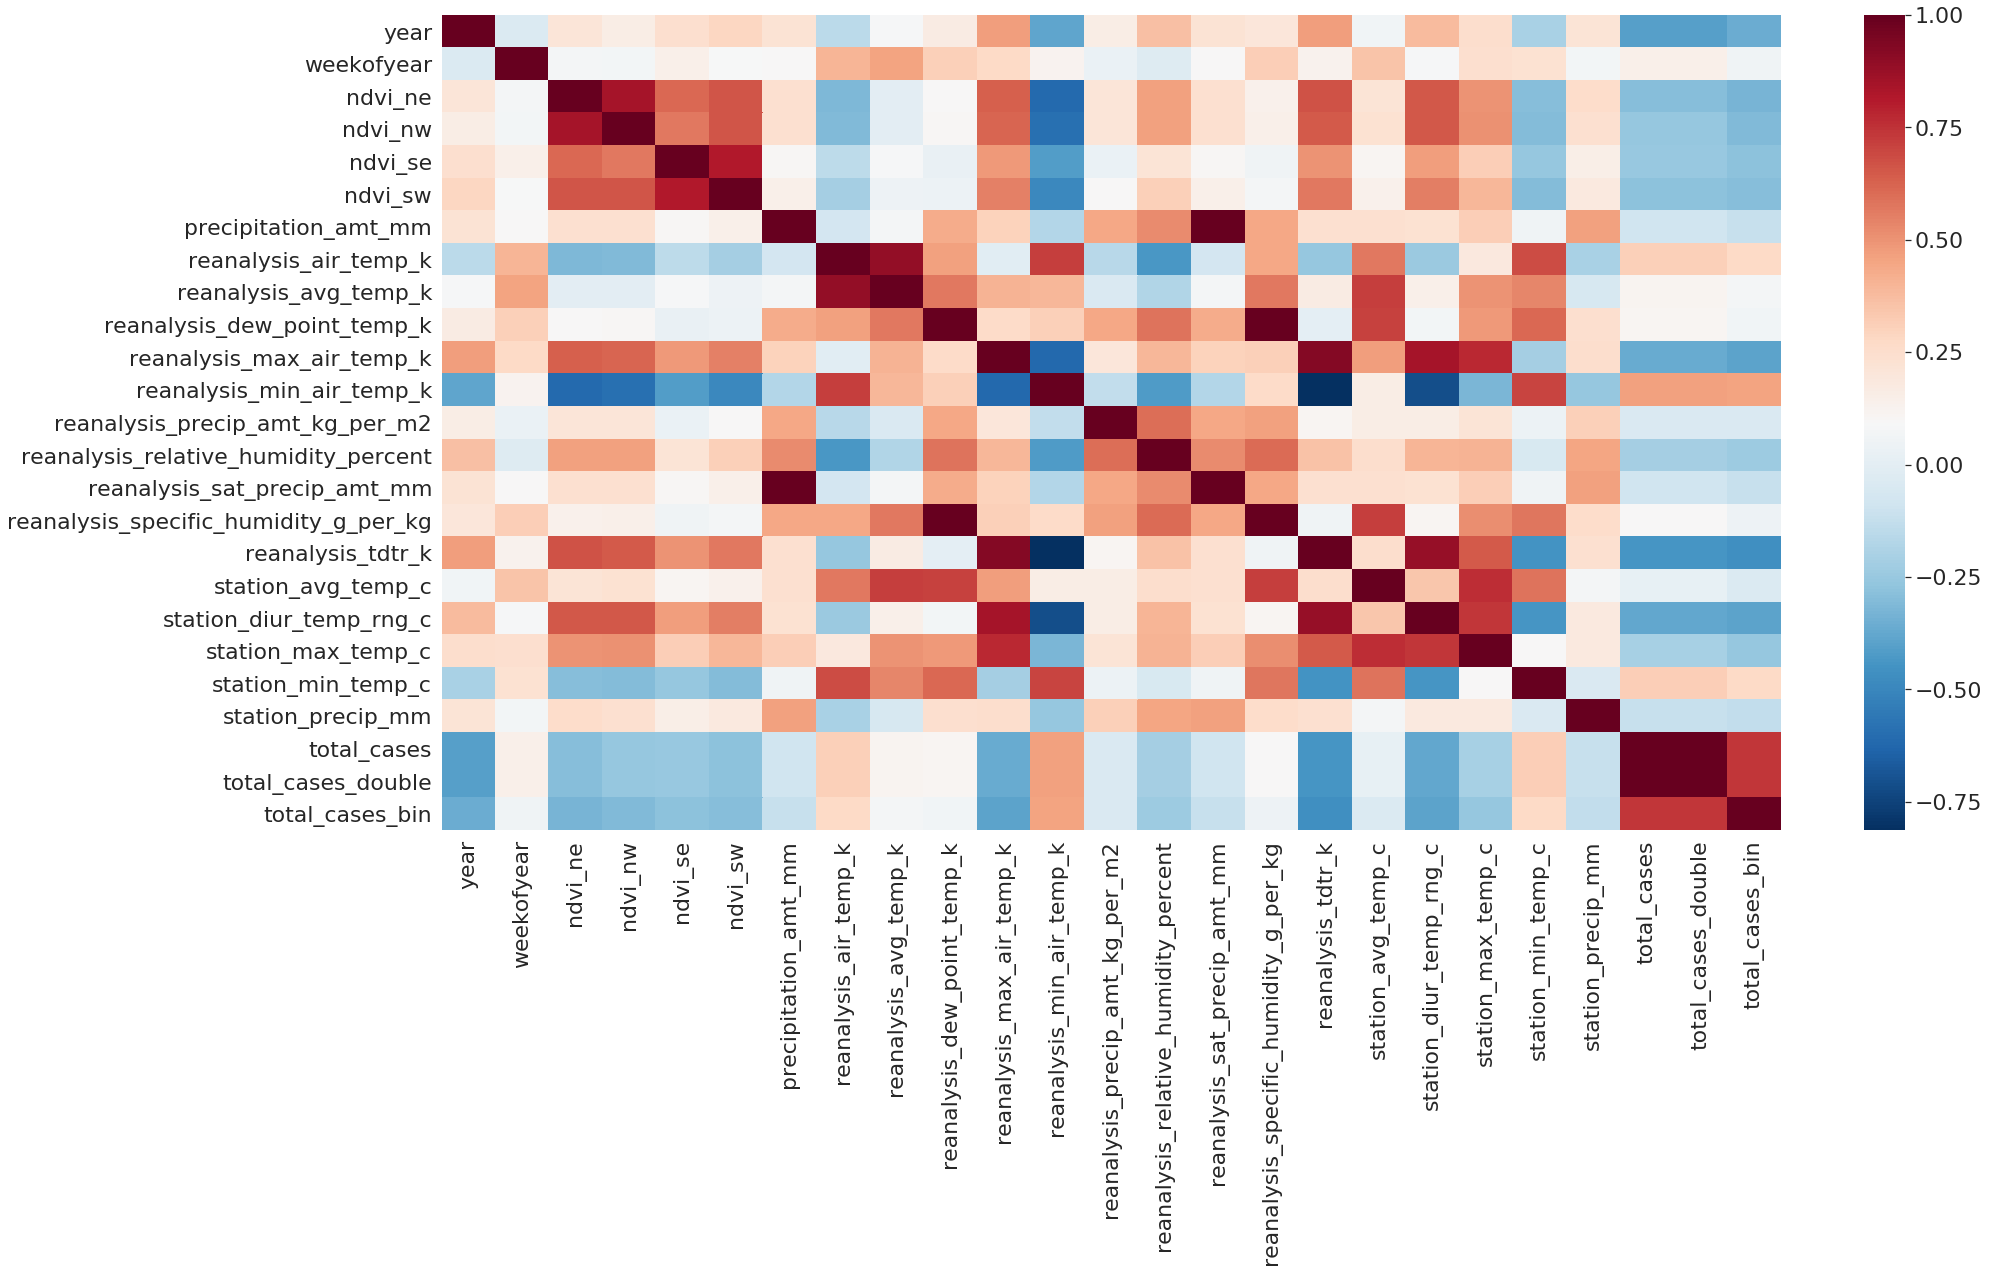

In [29]:
# Correlation plot of all variables
import seaborn as sns
pandas_integrated = integrated.toPandas()
corr = pandas_integrated.corr()
sns.set(font_scale = 2)
plt.figure(figsize=(30, 15))
sns.heatmap(corr, cmap="RdBu_r")
plt.show()

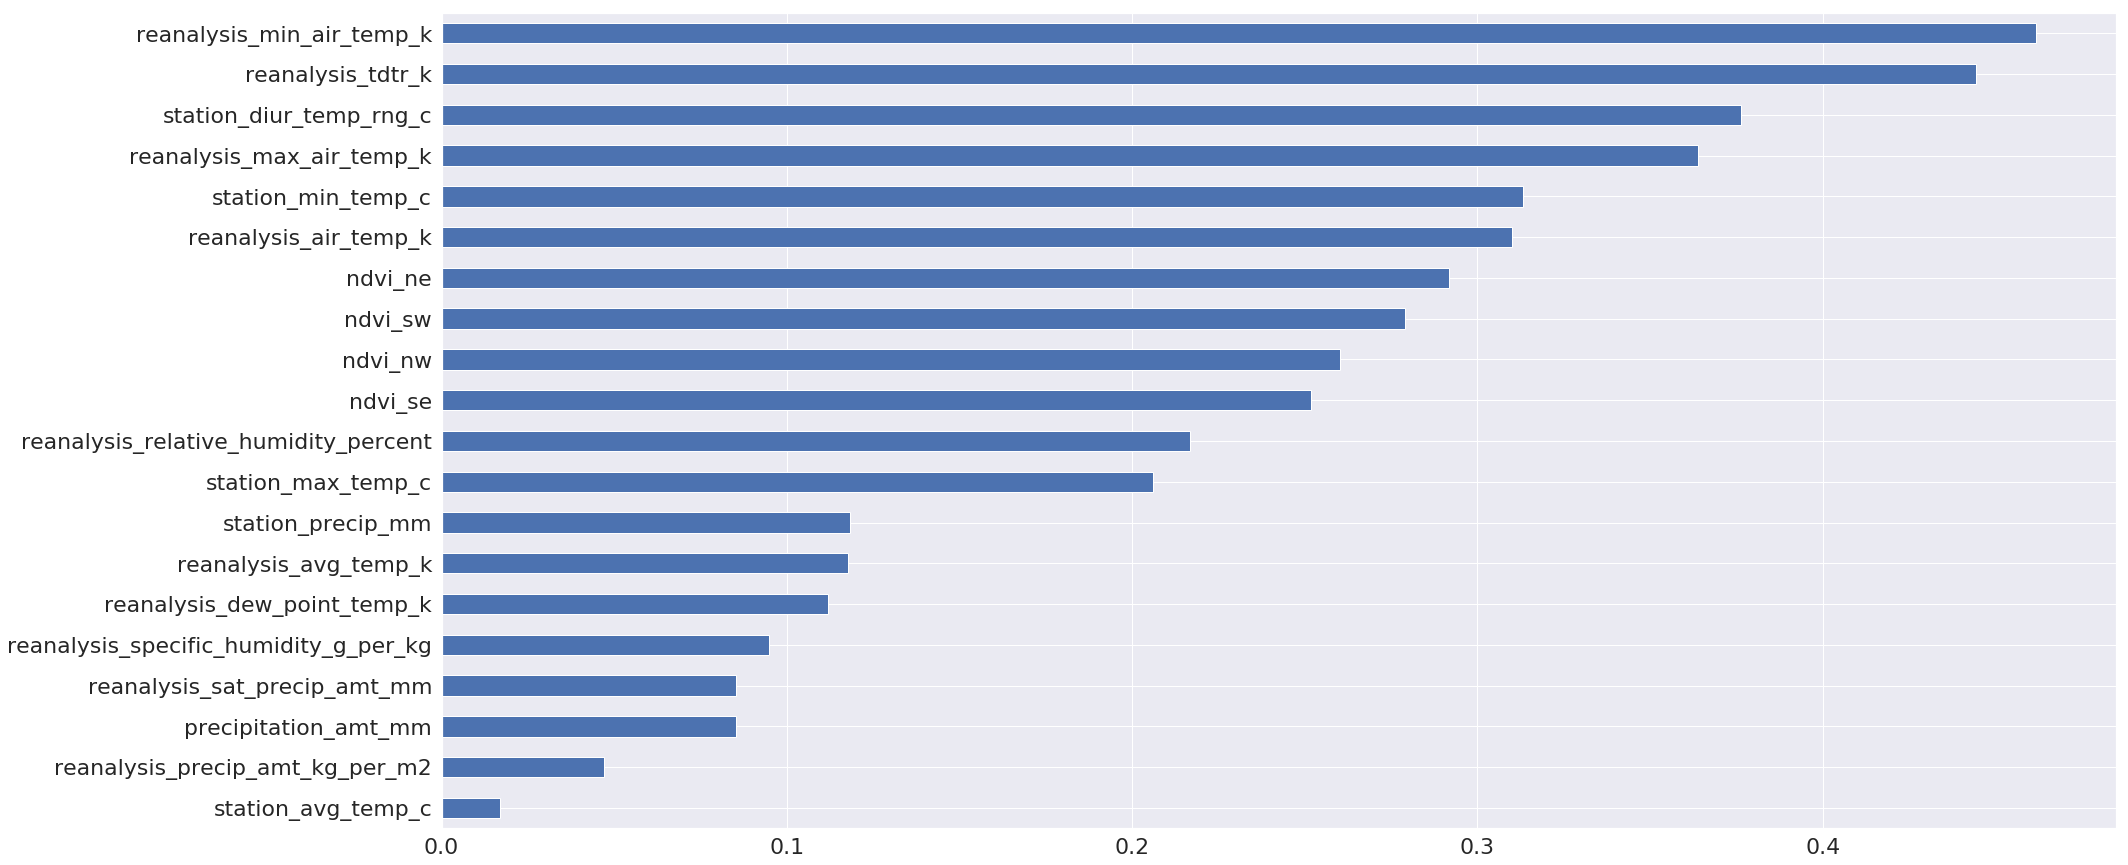

In [30]:
# Rank features according to correlation with total_cases
sns.set(font_scale = 2)
plt.figure(figsize=(30, 15))
abs(corr).total_cases.drop('year').drop('weekofyear').drop('total_cases').drop('total_cases_double').drop('total_cases_bin').sort_values().plot.barh()
plt.show()

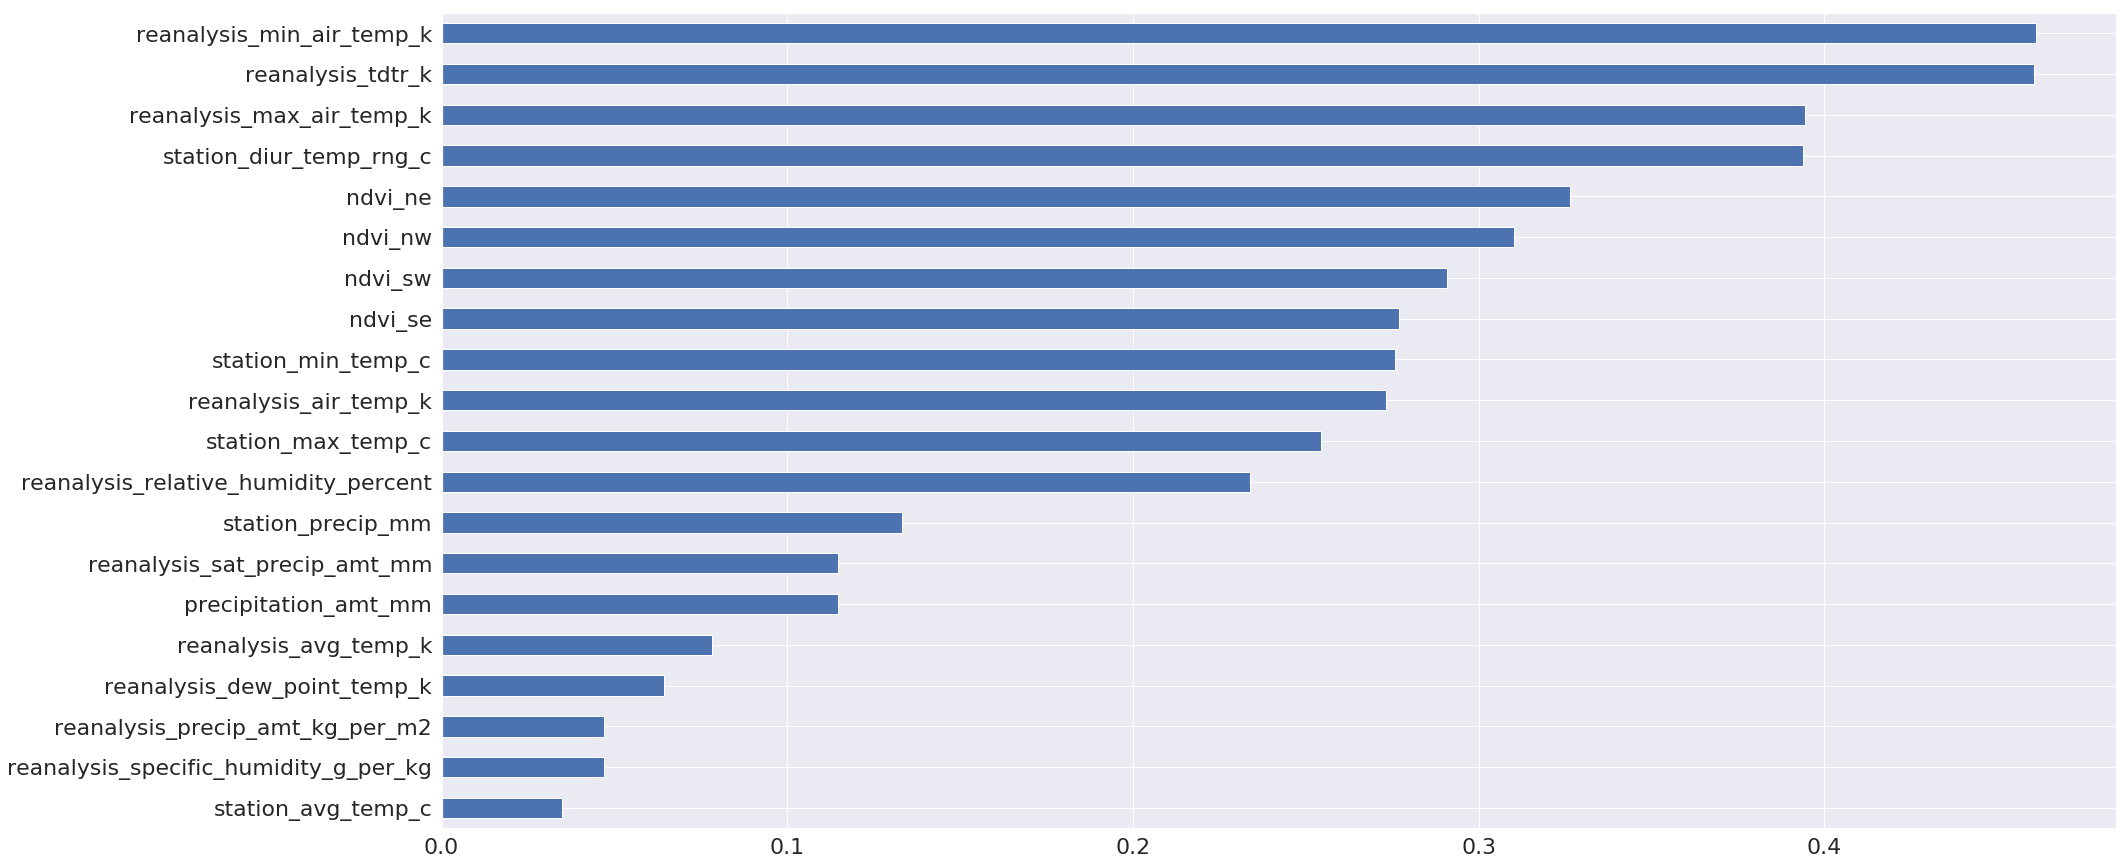

In [31]:
# Rank features according to correlation with total_cases_bin
sns.set(font_scale = 2)
plt.figure(figsize=(30, 15))
abs(corr).total_cases_bin.drop('year').drop('weekofyear').drop('total_cases').drop('total_cases_double').drop('total_cases_bin').sort_values().plot.barh()
plt.show()

### 4.2 Data projection

In [32]:
# Log-transform the six highly skewed variables
from pyspark.sql.functions import log
skewed_columns = ['reanalysis_precip_amt_kg_per_m2', 'station_precip_mm', 'precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm', 'reanalysis_tdtr_k', 'total_cases']
for col in skewed_columns:
    integrated = integrated.withColumn('log_'+col, log(integrated[col] + 1))

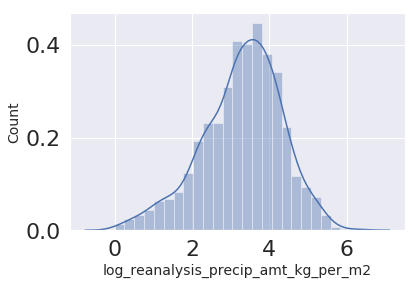

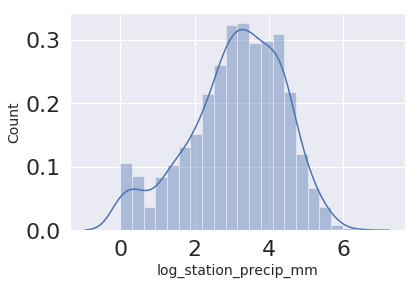

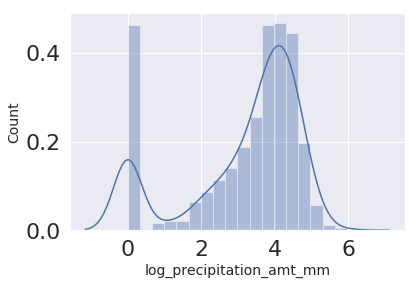

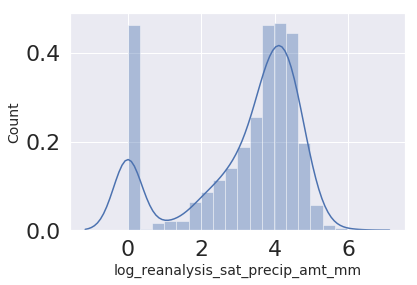

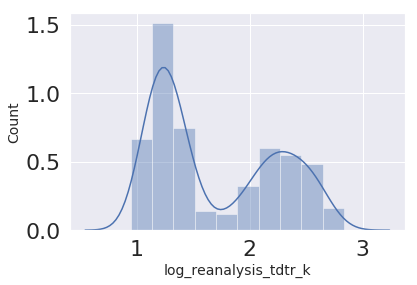

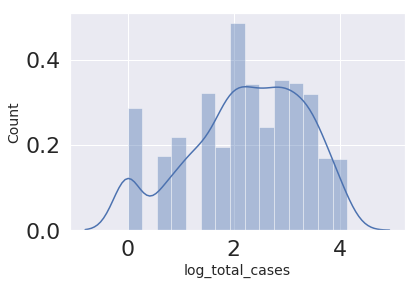

In [33]:
# Plot the six log-transformed variables
pandas_integrated = integrated.toPandas()
for col in skewed_columns:
    plt.xlabel('log_'+col, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    sns.distplot(pandas_integrated['log_'+col])
    plt.show()

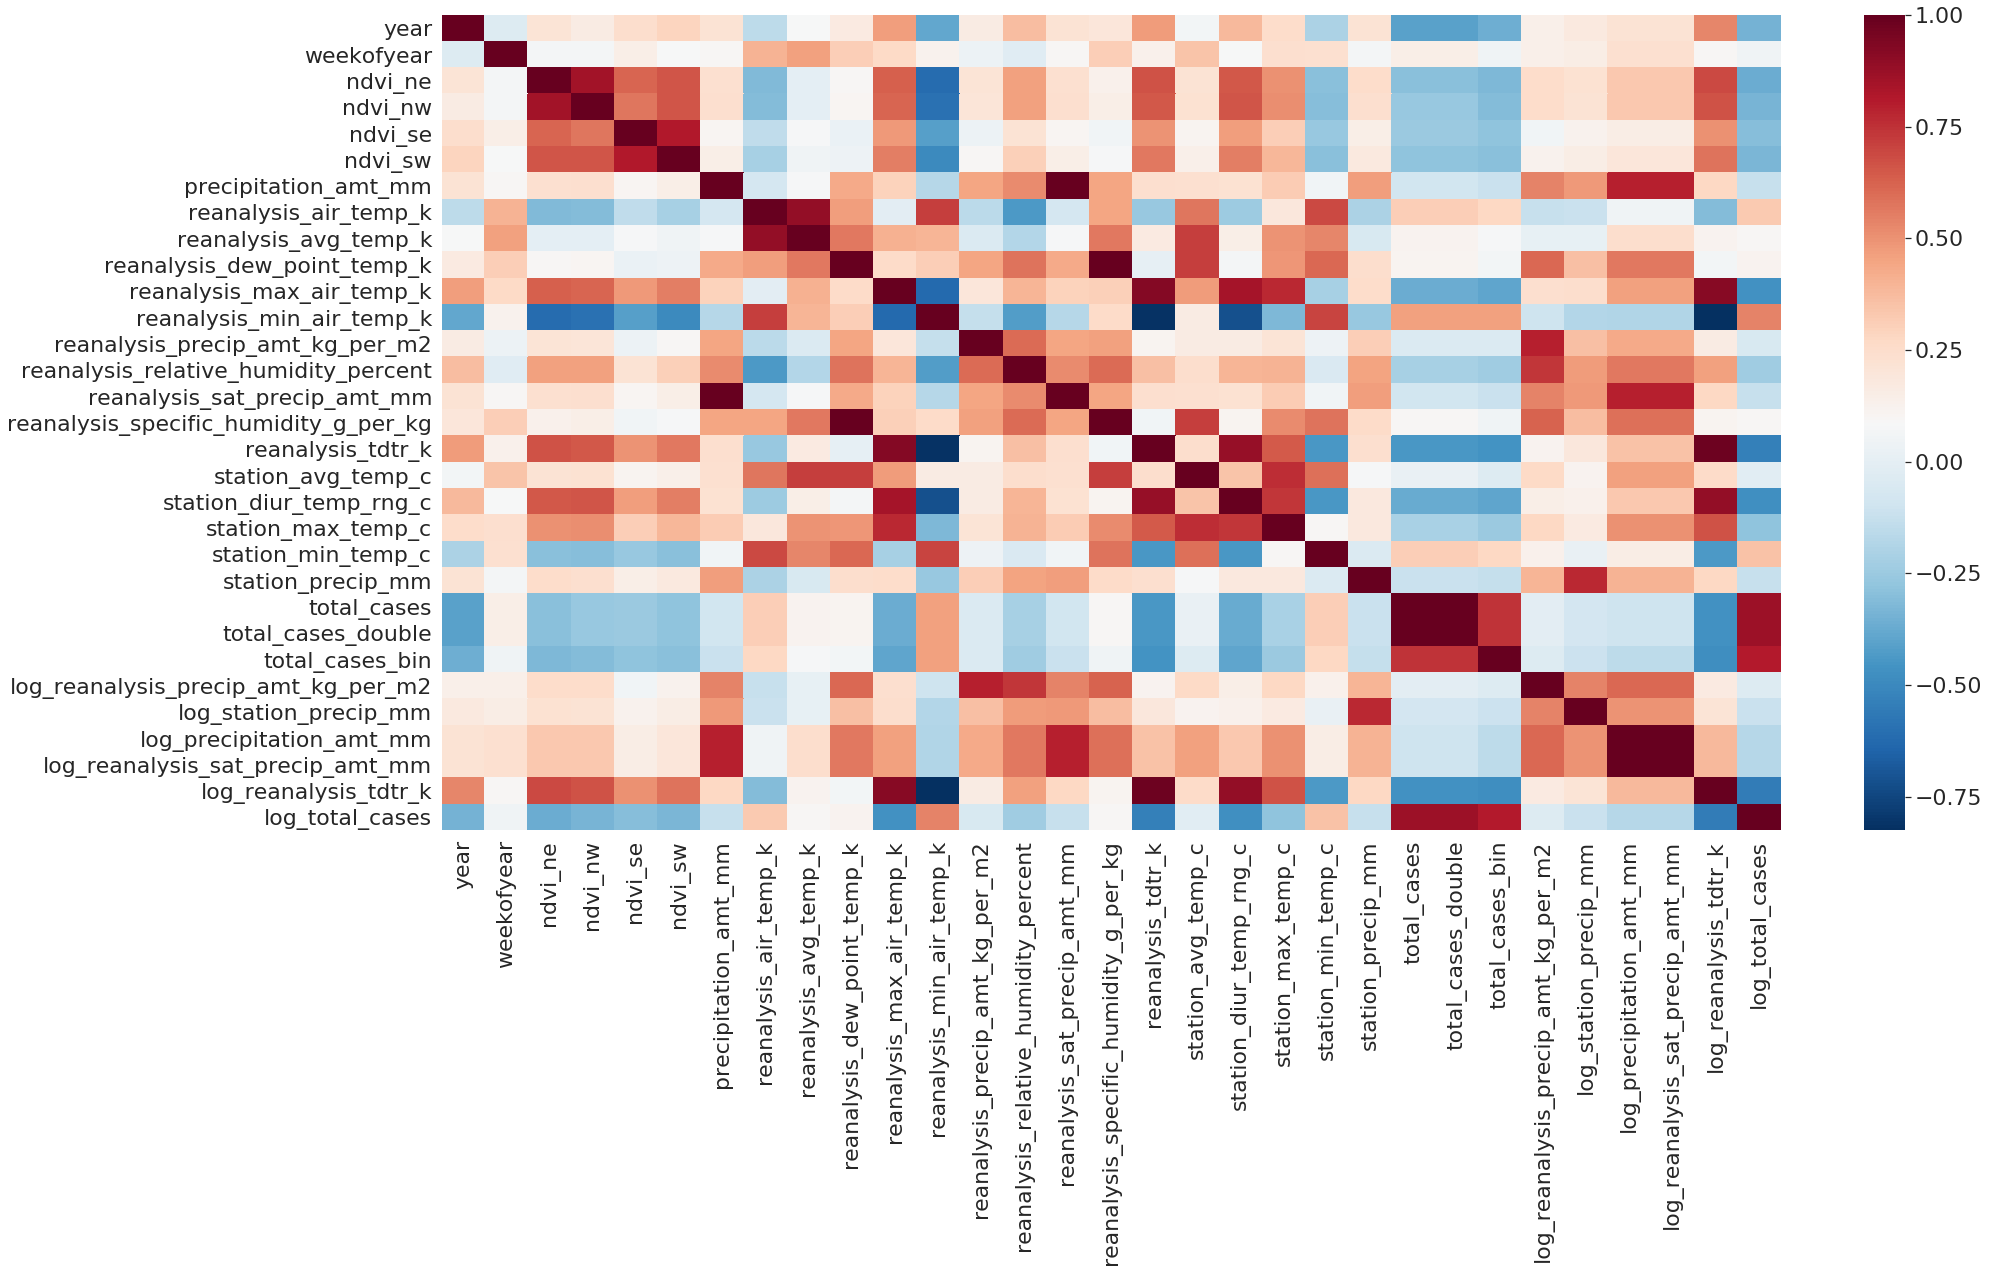

In [34]:
# Correlation plot of all variables
pandas_integrated = integrated.toPandas()
corr = pandas_integrated.corr()
sns.set(font_scale = 2)
plt.figure(figsize=(30, 15))
sns.heatmap(corr, cmap="RdBu_r")
plt.show()

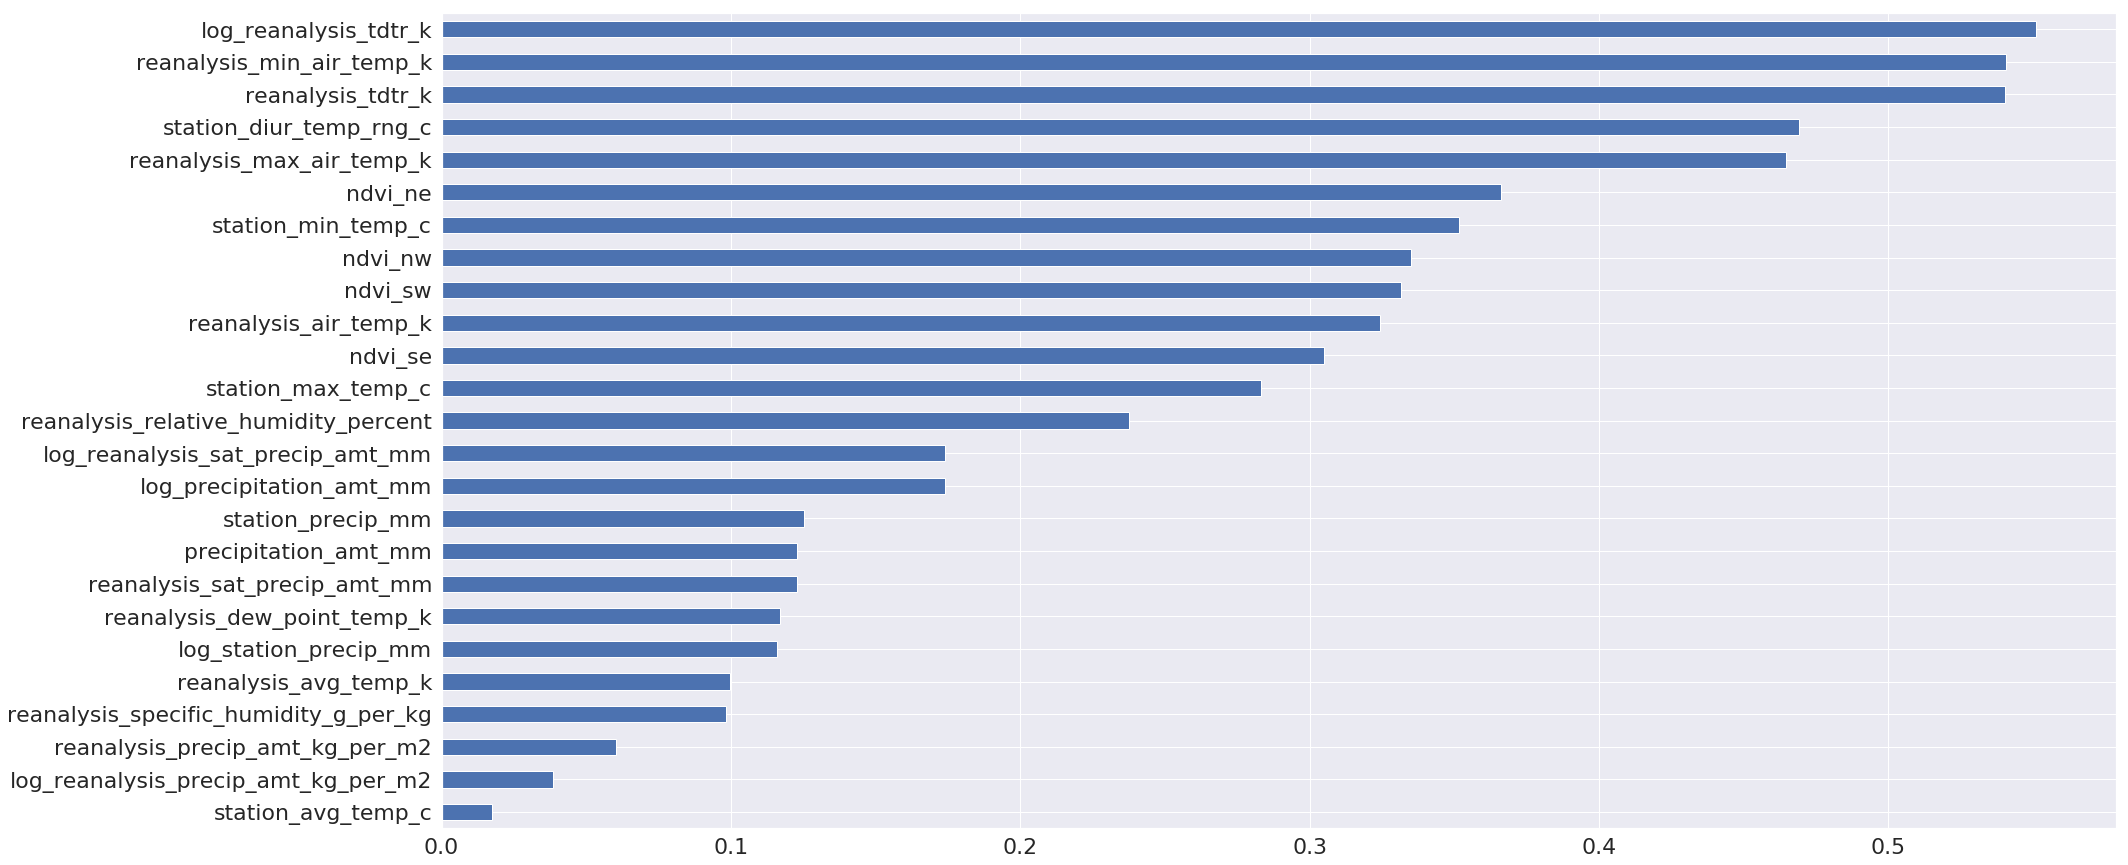

In [35]:
# Rank features according to correlation with log_total_cases
sns.set(font_scale = 2)
plt.figure(figsize=(30, 15))
abs(corr).log_total_cases.drop('log_total_cases').drop('year').drop('weekofyear').drop('total_cases').drop('total_cases_bin').drop('total_cases_double').sort_values().plot.barh()
plt.show()

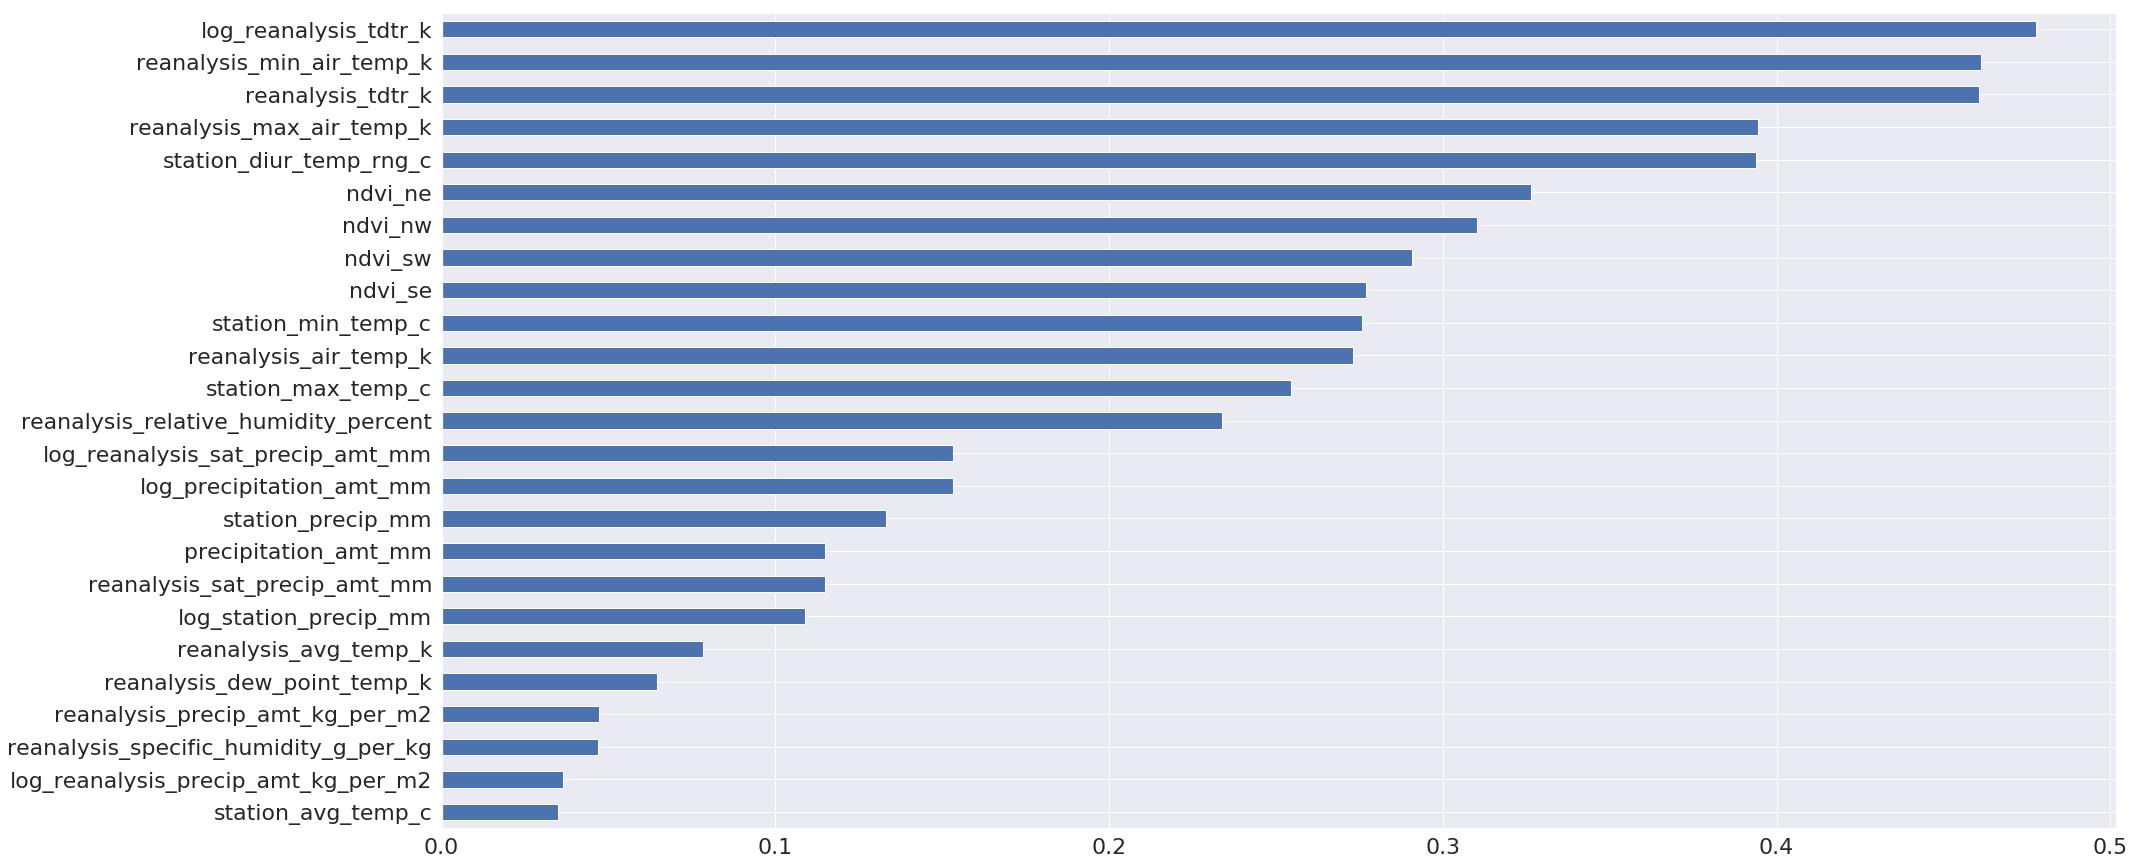

In [36]:
# Rank features according to correlation with total_cases_bin
sns.set(font_scale = 2)
plt.figure(figsize=(30, 15))
abs(corr).total_cases_bin.drop('log_total_cases').drop('year').drop('weekofyear').drop('total_cases').drop('total_cases_bin').drop('total_cases_double').sort_values().plot.barh()
plt.show()

In [37]:
# Write to CSV file
integrated.repartition(1).write.format('com.databricks.spark.csv').save("dengue-integrated.csv", header='true')